In [216]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from copy import deepcopy as copy
from disp import get_ordered_colors
from functools import partial

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2.0

In [217]:
def comp_r_out(t, w, b, a, u):
    onset_about_mean = np.inf
    if a > 1e-6 and w > 1e-6 and b > 1e-6:
        onset_about_mean = np.sqrt(np.log(w * a / b))
    t_star = np.exp(u - onset_about_mean)
    t_star_star = np.exp(u + onset_about_mean)
    r_out = np.where(np.bitwise_and(t >= t_star, t < t_star_star), w * a * np.exp(-np.square(np.log(t) - u)) - b, 0)
    return r_out

-5.0
-4.75
-4.5
-4.25
-4.0


Text(0, 0.5, 'Firing rate (Hz)')

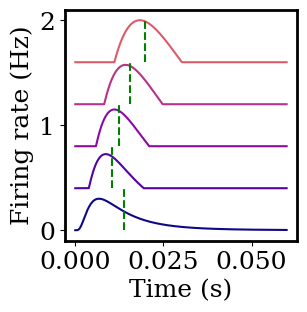

In [218]:
w_set = 0.009
b_set = 0.01

w = np.linspace(3, 18, 5)
b = np.linspace(0, 1.4, 5)

a_plot, T_plot = np.meshgrid(np.linspace(0.1, 0.1, 1), np.linspace(-5, -4, 5))

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 8
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(w.shape[0]):
    print(T_plot.flatten()[i])
    r_out = comp_r_out(t, w[i], b[i], a_plot.flatten()[i], T_plot.flatten()[i])
    t_mean = np.sum(t * r_out) / np.sum(r_out)
#     r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
#     r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out)
    axs.plot(np.arange(len(r_out)) * dt, r_out + 0.4 * i, c=colors[i])
    axs.plot(t_mean * np.ones(2), 0.4 * i + np.array([0, 0.4]), '--', color='green')
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

-5.0
-4.75
-4.5
-4.25
-4.0


Text(0, 0.5, 'Firing rate (Hz)')

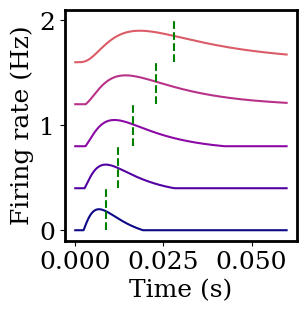

In [219]:
w_set = 0.009
b_set = 0.01

w = np.linspace(3, 3, 5)
b = np.linspace(0.1, 0, 5)

a_plot, T_plot = np.meshgrid(np.linspace(0.1, 0.1, 1), np.linspace(-5, -4, 5))

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 8
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(w.shape[0]):
    print(T_plot.flatten()[i])
    r_out = comp_r_out(t, w[i], b[i], a_plot.flatten()[i], T_plot.flatten()[i])
    t_mean = np.sum(t * r_out) / np.sum(r_out)
#     r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
#     r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out)
    axs.plot(np.arange(len(r_out)) * dt, r_out + 0.4 * i, c=colors[i])
    axs.plot(t_mean * np.ones(2), 0.4 * i + np.array([0, 0.4]), '--', color='green')
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

In [193]:
def comp_integrals(t, w, b, a, T):
    I1 = np.empty((w.flatten().shape[0]))
    I2 = np.empty((w.flatten().shape[0]))
    for i in range(w.flatten().shape[0]):
        r_out = comp_r_out(t, w.flatten()[i], b.flatten()[i], a.flatten()[i], T.flatten()[i])
        I1[i] = np.sum(r_out)
        I2[i] = np.sum(np.square(r_out))
    return I1, I2

def comp_changes(t, w, b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    I1, I2 = comp_integrals(t, w, b, a, T)
    print(I2.mean())
    print(I1.mean())
    delta_b = b_rate * (b_coef_I1 * I1 + b_coef_I2 * I2 - b_set)
    delta_w = w_rate * (w_set - w_coef_I2 * I2 - w_coef_I1 * I1)
    return delta_w, delta_b

278504.68767282495
6788.460123698734
397863.84034262656
9697.80215092447


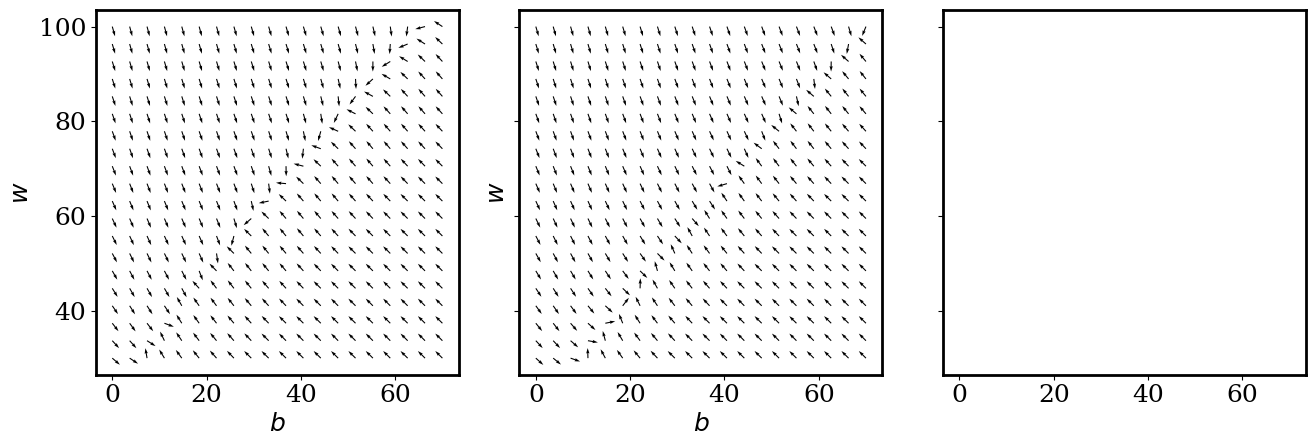

In [211]:
w_set = 1e5
b_set = 5000

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(30, 100, 20), np.linspace(0, 70, 20))

# panel 1
T = np.array([0.007] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 0.25, 5, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
T = np.array([0.01] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 0.25, 5, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[1].set_ylabel(r'$w$')
axs[1].set_xlabel(r'$b$')

# # panel 3
# T = np.array([0.012])
# a = np.array([10])

# delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
# norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

# axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

# fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
# fixed_point = fixed_points[0]
# print(fixed_point)
# axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

# print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))

fig.tight_layout()

278504.68767282495
6788.460123698734
397863.84034262656
9697.80215092447


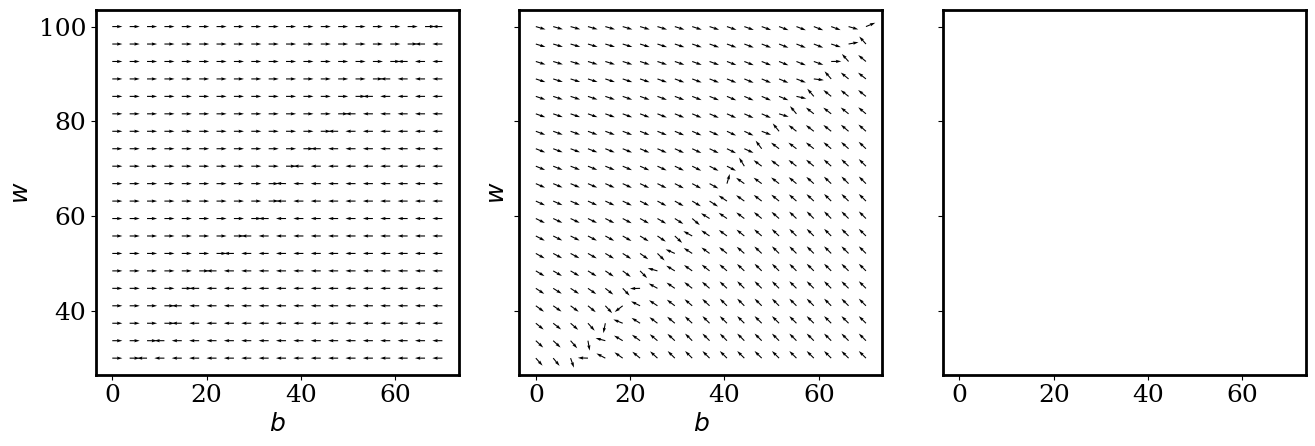

In [215]:
w_set = 5000
b_set = 1e5

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(30, 100, 20), np.linspace(0, 70, 20))

# panel 1
T = np.array([0.007] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 0.25, 5, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
T = np.array([0.01] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 5, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[1].set_ylabel(r'$w$')
axs[1].set_xlabel(r'$b$')

# # panel 3
# T = np.array([0.012])
# a = np.array([10])

# delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
# norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

# axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

# fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
# fixed_point = fixed_points[0]
# print(fixed_point)
# axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

# print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))

fig.tight_layout()

### Make delay vs amp evolution plot

In [ ]:
w_set = 5000
b_set = 1e5

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(30, 100, 20), np.linspace(0, 70, 20))

# panel 1
T = np.array([0.007] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 0.25, 5, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
T = np.array([0.01] * 400)
T = np.log(T)
a = np.array([1] * 400)

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1

dt = 0.00005
t = np.linspace(0, 1, int(1 / dt))

delta_w, delta_b = comp_changes(t, w, b, a, T, w_set, b_set, 5, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)

norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

axs[1].set_ylabel(r'$w$')
axs[1].set_xlabel(r'$b$')

# # panel 3
# T = np.array([0.012])
# a = np.array([10])

# delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
# norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

# axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

# fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
# fixed_point = fixed_points[0]
# print(fixed_point)
# axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

# print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))

fig.tight_layout()